In [ ]:
"""For google colab workflow - mounts Google Drive and go to it"""
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('./gdrive/MyDrive/Projects/RNN_for_GCPL')

In [1]:
"""For local machine - go to root directory"""
import os
os.chdir('../')

In [2]:
"""Imports all necessary libs"""
import os
import sys
import numpy as np
from sys import getsizeof
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from itertools import product
import pickle
import math
import shutil
import torch
from torch.utils.data import Dataset
import scipy as sp
from scipy.optimize import curve_fit
import sklearn
from Code.setup import *
import datetime as dt
import time
import torch.nn as nn
import copy
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
import RNN_for_GCPL.setup

In [3]:
"""For compatibility - cd to folder with data and models"""
os.chdir('../RNN_for_GCPL/')

In [27]:
savepath = r'data/v4/30/main'
dataset_validate = GCPL_dataset_resampled3(r'data/v4/120/validate')
dataset_rs2 = GCPL_dataset_resampled3(savepath)

In [ ]:
dataset_rs2[2]

In [5]:
seedEverything(seed=DEFAULT_RANDOM_SEED)
input_dim = 2
output_dim = 20
num_layers = 2
bidir= True
lr = 5e-4
init_model = MyGRU(input_dim, output_dim, num_layers=num_layers,bidir = bidir)
criterion = nn.MSELoss(reduction='none')
best_model = MyGRU(input_dim, output_dim, num_layers=num_layers,bidir = bidir)
# kf = KFold(5, shuffle=True, random_state=DEFAULT_RANDOM_SEED)
gkf = GroupKFold(4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
models = []
# params = [ (30,3,False), (60, 4, True)]
params = [(20, 2, False), (20, 2, True), (30, 3, True)]
for a,b,c in params:
    model = MyGRU(input_dim, a, num_layers=b, bidir=c)
    models.append(model)
sampling = [30, 60, 120, 180, 300]

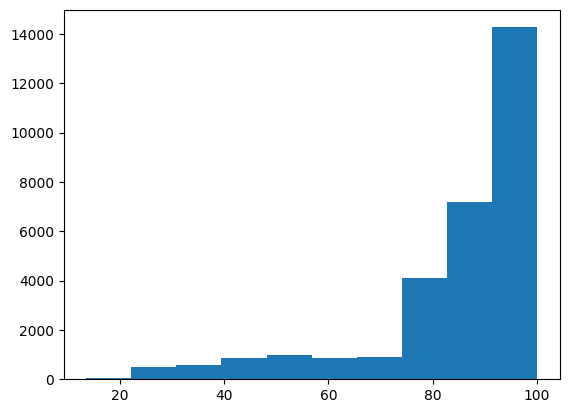

In [28]:
probs = balancing(dataset_rs2, 10)
soh, info = statistics(dataset_rs2)
clear_output()

In [54]:
class BucketSampler(torch.utils.data.Sampler):
    
    def __init__(self, lengths, buckets=(50,500,50), shuffle=True, batch_size=32, drop_last=False):
        
        super().__init__(lengths)
        
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.drop_last = drop_last
        
        assert isinstance(buckets, tuple)
        bmin, bmax, bstep = buckets
        assert (bmax - bmin) % bstep == 0
        
        buckets = defaultdict(list)
        for i, length in enumerate(lengths):
            if length > bmin:
                bucket_size = min((length // bstep) * bstep, bmax)
                buckets[bucket_size].append(i)
                
        self.buckets = dict()
        for bucket_size, bucket in buckets.items():
            if len(bucket) > 0:
                self.buckets[bucket_size] = torch.tensor(bucket, dtype=torch.int, device='cpu')
        
        # call __iter__() to store self.length
        self.__iter__()
            
    def __iter__(self):
        
        if self.shuffle == True:
            for bucket_size in self.buckets.keys():
                self.buckets[bucket_size] = self.buckets[bucket_size][torch.randperm(self.buckets[bucket_size].nelement())]
                
        batches = []
        for bucket in self.buckets.values():
            curr_bucket = torch.split(bucket, self.batch_size)
            if len(curr_bucket) > 1 and self.drop_last == True:
                if len(curr_bucket[-1]) < len(curr_bucket[-2]):
                    curr_bucket = curr_bucket[:-1]
            batches += curr_bucket
            
        self.length = len(batches)
        
        if self.shuffle == True:
            random.shuffle(batches)
            
        return iter(batches)
    
    def __len__(self):
        return self.length


In [39]:
def collate_batch_length(batch):
    sample_list = []
    label_list = []
    lengths = []
    for i in batch:
        sample = np.stack([i['E'], i['I']],axis=-1)
        sample_list.append(torch.tensor(sample, dtype=torch.float32))
        label_list.append(i['SoH'])
        lengths.append(len(i['E']))
    sequence_pad = nn.utils.rnn.pad_sequence(sample_list)
    labels = torch.tensor(label_list, dtype=torch.float32)
    lengths_torch = torch.tensor(lengths, dtype=torch.float32)
    return sequence_pad, labels, lengths_torch  


In [65]:
missed_length = []
n_bins = 10
_ , ind = statistics(dataset_rs2)
for k, (train_indices, val_indices) in enumerate(gkf.split(dataset_rs2, groups=info.Pouch)):
    seedEverything(seed=DEFAULT_RANDOM_SEED)
    train_set = torch.utils.data.Subset(dataset_rs2, train_indices)
    
    min_length =  ind.loc[train_indices,'Len'].min()
    max_length = ind.loc[train_indices,'Len'].max()
    max_length += n_bins - (max_length-min_length)% n_bins
    print(min_length, max_length)
    val_set = torch.utils.data.Subset(dataset_rs2, val_indices)
    sampler = torch.utils.data.WeightedRandomSampler(probs[train_indices], len(train_indices)) 
    bucket_sampler = BucketSampler(ind.loc[train_indices,'Len'].to_numpy(), buckets = (min_length, max_length, n_bins), batch_size=batch_size)
    # train_loader = torch.utils.data.DataLoader(train_set, batch_size =1,  batch_sampler=bucket_sampler, collate_fn=collate_batch_length)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size =batch_size, shuffle=True, collate_fn=collate_batch_length)

    val_loader = torch.utils.data.DataLoader(val_set, batch_size, shuffle=True, collate_fn=collate_batch)
    miss_ = []
    for data, labels, length in train_loader:
        m = data.shape[0]- length.mean()
        miss_.append([m, data.shape[0],length.mean()])
    miss_ = torch.tensor(miss_)
    missed_length.append(miss_)
    print(miss_.mean(axis=0))


175 655
tensor([105.2509, 624.2316, 518.9808])
175 655
tensor([114.7200, 621.9972, 507.2772])
175 655
tensor([112.2984, 621.2206, 508.9223])
211 651
tensor([100.4270, 621.7288, 521.3018])


In [30]:
draw_every = 25
num_epochs = 75
save_every = 10
batch_size = 64
n_bins = 10
_ , ind = statistics(dataset_rs2)
for m in sampling:
    dataset_rs2 = GCPL_dataset_resampled3(f'data/v4/{m}/main')
    dataset_validate = GCPL_dataset_resampled3(f'data/v4/{m}/validate')
    for l, init_model in enumerate(models):
        path = f'./models/v10/{m}/{l}'
        for k, (train_indices, val_indices) in enumerate(gkf.split(dataset_rs2, groups=info.Pouch)):
            seedEverything(seed=DEFAULT_RANDOM_SEED)
            min_length =  ind.loc[train_indices,'Len'].min()
            max_length = ind.loc[train_indices,'Len'].max()
            max_length += n_bins - (max_length-min_length)% n_bins
            train_set = torch.utils.data.Subset(dataset_rs2, train_indices)
            val_set = torch.utils.data.Subset(dataset_rs2, val_indices)
            # sampler = torch.utils.data.WeightedRandomSampler(probs[train_indices], len(train_indices)) 
            # train_loader = torch.utils.data.DataLoader(train_set, batch_size, collate_fn=collate_batch, sampler=sampler)
            # val_loader = torch.utils.data.DataLoader(val_set, batch_size, shuffle=True, collate_fn=collate_batch)
            bucket_sampler_train = BucketSampler(ind.loc[train_indices,'Len'].to_numpy(), buckets = (min_length, max_length, n_bins), batch_size=batch_size)
            bucket_sampler_val = BucketSampler(ind.loc[val_indices,'Len'].to_numpy(), buckets = (min_length, max_length, n_bins), batch_size=batch_size)
            train_loader = torch.utils.data.DataLoader(train_set, batch_size =1,  batch_sampler=bucket_sampler_train, collate_fn=collate_batch)
            model = copy.deepcopy(init_model)
            val_loader = torch.utils.data.DataLoader(val_set, batch_size =1,  batch_sampler=bucket_sampler_val, collate_fn=collate_batch)
            model = copy.deepcopy(init_model)
            model.to(device)
            optimizer =  torch.optim.Adam(model.parameters(), lr=lr)
            sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
            handler = ModelHandler(model, 1e6, f'20 neurons, 2 layers, 120s sampling, 80% train, 20% val, k-fold No {k}.', path= path, kfold=True)
            pp = ProgressPlotter()
            counter = 0
            for i in range(num_epochs):
                model.train()
                loss_val = 0
                loss_train = 0
                for data, labels in train_loader:
                    optimizer.zero_grad()
                    preds = model(data.to(device))
                    loss = torch.sum(criterion(preds, labels.to(device)))
                    loss.backward()
                    optimizer.step()
                    loss_train += loss.detach().cpu()
                
                
                with torch.no_grad():
                    loss_train = loss_train/len(train_loader)
                    pp.add_scalar('loss_train', loss_train.detach().cpu().numpy())
                    model.eval()
                    for data, labels in val_loader:
                        preds = model(data.to(device))
                        loss = torch.sum(criterion(preds, labels.to(device)))
                        loss_val += loss.detach().cpu()
                    loss_val = loss_val/len(val_set)
                    sheduler.step(loss_val)
                    handler.check_loss(loss_val, draw_every)
                    pp.add_scalar('loss_val', loss_val.detach().cpu().numpy())
                    if loss_val > handler.best_loss:
                        counter +=1
                    else:
                        counter = 0
                    if (i+1)%draw_every == 0:
                        pp.display([['loss_train', 'loss_val']])
                    print(i, counter, loss_train*2500, loss_val*2500)
                if (i+1)%save_every==0:
                    handler.save(kfold_number=k)
                    
                    
            handler.add_pp(pp)
            handler.display()
            handler.save(kfold_number=k)
            with torch.no_grad():
                loss_val = []
                for data, labels in val_loader:
                    preds = model(data.to(device))
                    loss = criterion(preds, labels.to(device))
                    loss_val.append(loss)
                loss_val = torch.hstack(loss_val)
                print(loss_val.mean(), loss_val.std())


torch.Size([630, 64, 20])
torch.Size([601, 64, 20])
torch.Size([595, 64, 20])
torch.Size([597, 64, 20])
torch.Size([627, 64, 20])
torch.Size([593, 64, 20])


KeyboardInterrupt: 

In [31]:
data

tensor([[[0.4652, 0.4244],
         [0.2750, 0.4994],
         [0.3213, 0.4998],
         ...,
         [0.5390, 0.4174],
         [0.5236, 0.4997],
         [0.3478, 0.3102]],

        [[0.5171, 0.5002],
         [0.3506, 0.4997],
         [0.4247, 0.5000],
         ...,
         [0.6012, 0.4999],
         [0.6377, 0.4999],
         [0.3933, 0.5002]],

        [[0.5378, 0.5002],
         [0.4122, 0.4997],
         [0.4696, 0.5000],
         ...,
         [0.6150, 0.4999],
         [0.6996, 0.4999],
         [0.4223, 0.5002]],

        ...,

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         ...,
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         ...,
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000]],

        [[0.0000, 0.0000],
         [0.0000, 0.0000],
         [0.0000, 0.0000],
         ...,
 

In [ ]:
"""Loss checking"""
loss = []
model = copy.deepcopy(init_model) 
path= f'./models/v127/2'
handler = ModelHandler(model, 1e6, path= f'./models/v2/', kfold=True)
batches = next(os.walk(path))[1]
loss_ = []
epochs_ = []
for batch in batches:
    batchpath = path+ '/' + batch
    handler.load(batchpath)
    loss_.append(handler.best_loss.cpu())
loss.append(loss_)
loss = np.array(loss)*2500
print(str(np.mean(loss))+ '±' + str(np.std(loss)))
loss

In [8]:
def load(path_):
    if path_.split('.')[-1] == 'pt':
        path = '/'.join(path.split('/')[:-1])
        name = path_.split('/')[-1]
        checkpoint = torch.load(path+ '/' + name, map_location=torch.device('cpu'))
        loss = [checkpoint['loss'].numpy()]
    else:
        path = path_
        files = next(os.walk(path_))[2]
        x = lambda x: int(x.split('_')[-1].split('.')[0].split('(')[0])
        files.sort(key=x)
        loss = []
        for name in files:
            checkpoint = torch.load(path+ '/' + name, map_location=torch.device('cpu'))
            loss.append(checkpoint['loss'].numpy())
    return np.array(loss)


In [ ]:
path = f'./models/v10'
loss = {}
for root, dirs, files in os.walk(path):
    if dirs:
        continue
    if not files:
        continue

    loss[root] = load(root)*2500
loss

In [9]:
def collate_batch_named(batch, named=True):
    sample_list = []
    label_list = []
    pouch = []
    cycle = []
    for i in batch:
        sample = np.stack([i['E'], i['I']],axis=-1)
        sample_list.append(torch.tensor(sample, dtype=torch.float32))
        label_list.append(i['SoH'])
        pouch.append(i['Pouch'])
        cycle.append(i['Cycle'])
    sequence_pad = nn.utils.rnn.pad_sequence(sample_list)
    labels = torch.tensor(label_list, dtype=torch.float32)
    if not named:
        return sequence_pad, labels    
    else:
        return sequence_pad, labels, pouch, cycle

In [10]:
def detailed_loss(handler, val_loader):
    with torch.no_grad():
        loss = []
        pouches = []
        soh = []
        pred = []
        cycles = []
        for data, labels, pouch, cycle in val_loader:
            preds = handler.best_model(data)
            pred.extend(preds)
            loss_ = criterion(preds, labels)
            loss.append(loss_)
            pouches.extend(pouch)
            cycles.extend(cycle)
            soh.extend(labels)
        
        loss = torch.hstack(loss)
        soh = torch.Tensor(soh)*50+50
        pred = torch.Tensor(pred)*50+50
        loss *= 2500 
        results = pd.DataFrame({'Pouch':pouches,'Cycle':cycles, 'Loss':loss, 'SoH':soh,'Pred':pred} )
        # results.sort_values(by='Loss',axis=0, ascending=0,inplace=True)
        return results

In [11]:
batch_size = 64
model_version = 10
losses = []
for k in range(3):
    for s in sampling:
        datapath = f'data/v4/{s}/'
        modelpath = f'./models/v{model_version}/{s}/{k}'
        dataset_validate = GCPL_dataset_resampled3(datapath+'validate')
        dataset_rs2 = GCPL_dataset_resampled3(datapath+'main')
        main_loader = torch.utils.data.DataLoader(dataset_rs2, batch_size, shuffle=False, collate_fn=collate_batch_named)
        val_loader = torch.utils.data.DataLoader(dataset_validate, batch_size, shuffle=False, collate_fn=collate_batch_named)
        for i in next(os.walk(modelpath))[1]:
            init_model = copy.deepcopy(models[k])
            path = modelpath + f'/{i}'
            print(path)
            handler = ModelHandler(init_model)
            handler.load(path)
            result_main = detailed_loss(handler, main_loader)
            result_val = detailed_loss(handler, val_loader)
            result = pd.concat([result_main, result_val])
            loss = pd.concat([result.groupby('Pouch').Loss.mean(), result.groupby('Pouch').Loss.std()], axis=1)
            loss.columns = [f'{s}/{k}/{i}_Mean', f'{s}/{k}/{i}_Std']
            losses.append(loss)
f_loss = pd.concat(losses, axis=1)


./models/v10/30/0/0
./models/v10/30/0/1
./models/v10/30/0/2
./models/v10/30/0/3
./models/v10/60/0/0
./models/v10/60/0/1
./models/v10/60/0/2
./models/v10/60/0/3
./models/v10/120/0/0
./models/v10/120/0/1
./models/v10/120/0/2
./models/v10/120/0/3
./models/v10/180/0/0
./models/v10/180/0/1
./models/v10/180/0/2
./models/v10/180/0/3
./models/v10/300/0/0
./models/v10/300/0/1
./models/v10/300/0/2
./models/v10/300/0/3
./models/v10/30/1/0
./models/v10/30/1/1
./models/v10/30/1/2
./models/v10/30/1/3
./models/v10/60/1/0
./models/v10/60/1/1
./models/v10/60/1/2
./models/v10/60/1/3
./models/v10/120/1/0
./models/v10/120/1/1
./models/v10/120/1/2
./models/v10/120/1/3
./models/v10/180/1/0
./models/v10/180/1/1
./models/v10/180/1/2
./models/v10/180/1/3
./models/v10/300/1/0
./models/v10/300/1/1
./models/v10/300/1/2
./models/v10/300/1/3
./models/v10/30/2/0
./models/v10/30/2/1
./models/v10/30/2/2
./models/v10/30/2/3
./models/v10/60/2/0
./models/v10/60/2/1
./models/v10/60/2/2
./models/v10/60/2/3
./models/v10/120

In [22]:
f_loss.iloc[:, 0::2]

,30/0/0_Mean,30/0/1_Mean,30/0/2_Mean,30/0/3_Mean,60/0/0_Mean,60/0/1_Mean,60/0/2_Mean,60/0/3_Mean,120/0/0_Mean,120/0/1_Mean,...,120/2/2_Mean,120/2/3_Mean,180/2/0_Mean,180/2/1_Mean,180/2/2_Mean,180/2/3_Mean,300/2/0_Mean,300/2/1_Mean,300/2/2_Mean,300/2/3_Mean
Pouch,,,,,,,,,,,,,,,,,,,,,
D01,101.347397,57.534409,77.919159,106.148079,273.894501,56.090595,143.012100,347.624603,451.044250,7.643609,...,179.888992,126.094353,43.394913,13.177094,57.825485,109.722656,511.114868,50.272324,375.908081,80.778839
D02,158.965347,41.241032,63.388298,73.532188,268.035522,39.735043,106.580276,346.194092,460.993622,8.780524,...,361.879608,268.361420,88.486771,15.217090,194.634720,244.052917,565.402100,50.919762,349.639313,50.493618
D03,72.458099,31.272238,46.091373,67.727539,200.814636,25.864735,88.198639,269.162964,361.065094,5.357224,...,212.084366,139.050110,33.024982,6.337669,71.346024,112.519691,430.561829,24.104149,468.251099,106.117523
D04,96.792534,32.175735,50.312389,64.801582,230.307037,29.074465,97.268570,297.979736,382.186340,5.440520,...,225.102524,162.606445,65.140152,8.158903,108.677505,140.485916,448.811249,29.670042,371.997620,61.974747
D05,149.146072,64.339729,100.950752,101.707184,346.256805,66.351967,153.818665,440.006409,567.362000,15.925620,...,324.747620,246.745132,91.486519,22.129862,158.500519,219.640121,580.515442,68.968376,330.175812,65.366997
D06,80.328262,49.982983,67.198647,87.168945,243.197083,51.872650,119.134636,310.193909,409.700378,9.976034,...,167.899231,109.991478,52.503731,13.567752,72.571938,102.839409,496.740021,46.413784,400.548157,76.500320
D07,15.899910,23.805731,18.143581,48.363625,138.690018,21.203211,79.874054,253.260742,353.753174,45.212345,...,382.608307,272.796997,115.243469,14.694341,174.702591,212.840469,558.850586,21.470823,576.184143,53.851093
D08,17.333038,28.760792,26.645704,46.005676,154.590622,29.099367,87.057320,280.701996,410.072113,51.081776,...,400.069183,282.743469,80.068367,24.578838,140.667816,204.566559,617.618896,32.489788,657.485657,56.186516
D09,40.922497,34.855824,22.817005,57.245159,143.476517,41.131050,87.545738,283.106689,462.693909,26.137560,...,453.536194,314.510986,109.319916,21.831556,178.605240,233.365814,785.863647,52.195446,691.653442,71.782310


,Mean,Std
Pouch,,
D01,68.060997,38.278269
D02,52.513660,34.745408
D04,38.839382,23.330934
D05,82.649055,33.745152
D06,55.029346,24.730092
D07,30.257469,243.985719
D08,35.369114,306.441101
D09,35.673515,181.485791
D10,68.014381,95.315308


In [71]:
losses

[[223.74605, 53.14933, 273.30228, 256.4489],
 [263.88367, 54.654358, 323.64536, 304.6447],
 [330.05325, 56.625156, 405.94247, 382.25626],
 [385.97293, 61.334618, 480.62753, 450.0757],
 [441.2682, 64.801636, 557.57416, 519.4676],
 [472.71698, 67.00185, 602.77203, 560.6851]]

In [73]:
losses

[[193.93025, 51.178204, 207.65775, 199.30264],
 [231.84923, 51.571613, 243.19287, 242.00317],
 [293.09564, 52.32532, 299.23056, 312.48822],
 [344.0031, 55.0254, 349.3528, 372.03607],
 [392.79312, 57.302197, 398.89038, 430.74908],
 [422.34427, 58.801193, 427.55176, 466.8911]]

In [76]:
losses

[[183.70222, 60.1177, 165.59593, 132.0471],
 [236.37271, 60.053402, 229.8053, 180.04543],
 [305.5516, 60.00611, 309.55496, 248.64053],
 [361.75558, 60.417294, 374.33307, 300.08716],
 [406.0127, 60.86874, 427.84875, 337.76956],
 [430.0377, 60.98239, 458.2646, 355.54343]]

In [83]:
losses__

[[[123.54533, 15.61033, 122.35774, 116.88406],
  [175.98842, 14.902732, 191.7217, 177.27821],
  [268.518, 16.422253, 305.3939, 281.25195],
  [382.70554, 14.142295, 444.79163, 410.3108],
  [498.36835, 15.233874, 599.5127, 544.9424],
  [560.9522, 15.306204, 684.92426, 620.6983]],
 [[128.5034, 17.801245, 125.28308, 127.39169],
  [170.402, 17.40125, 171.24883, 167.4393],
  [248.4183, 18.227213, 254.61143, 254.91347],
  [344.46606, 16.587713, 354.7642, 366.23077],
  [439.6137, 18.133171, 458.7818, 478.95816],
  [495.78638, 18.8436, 513.82104, 545.5704]],
 [[110.79289, 32.643345, 120.6524, 97.31644],
  [126.08669, 32.07492, 126.37168, 100.505165],
  [210.63629, 31.617138, 209.70842, 170.33368],
  [345.558, 30.300776, 341.4894, 276.65503],
  [452.07288, 30.363787, 452.1902, 360.65048],
  [502.50082, 30.772055, 511.77768, 400.6077]]]

In [85]:
losses__

[[[125.12909, 29.80547, 121.400856, 114.51289],
  [154.48021, 29.620342, 122.66538, 147.67305],
  [214.37671, 29.531881, 127.00425, 224.81421],
  [284.88824, 28.240183, 134.13173, 320.90237],
  [349.1445, 27.475492, 144.31952, 412.55106],
  [384.5671, 26.367496, 153.0634, 463.34668]],
 [[130.70111, 19.875414, 154.12709, 110.834145],
  [135.06134, 19.799328, 159.94261, 111.413124],
  [206.31067, 19.924215, 179.36496, 113.895836],
  [325.30057, 19.370089, 206.17511, 118.241554],
  [427.30142, 19.447706, 246.4725, 124.9536],
  [461.2362, 19.083412, 276.63385, 130.62596]],
 [[107.73308, 51.237183, 109.73605, 63.74831],
  [110.21881, 51.286777, 115.34668, 63.900253],
  [122.79714, 51.471783, 201.40724, 64.49132],
  [141.48915, 52.04614, 325.5447, 65.908775],
  [176.34526, 53.160267, 458.55328, 68.62666],
  [205.7013, 54.6825, 522.4119, 71.81401]]]

In [ ]:
loss = {}
for s in sampling:
    l_ = {}
    for i in range(3):
        path = f'./models/v10/{s}/{i}'
        batches = next(os.walk(path))[1]
        loss_ = []
        for batch in batches:
            batchpath = path+ '/' + batch
            a = load(batchpath)
            loss_.append(a)
        loss_ = torch.tensor(loss_)*2500
        l_[i] = loss_
        print(s, i, f'{loss_.mean():.3}±{loss_.std():.3}')
    loss[s] = l_

In [ ]:
length = []
soh = []
info = pd.DataFrame({
            'Pouch':[],
            'SoH':[],
            "Len":[],
            })
for i in range(len(dataset_rs2)):
    one = len(dataset_rs2[i]['E'])
    soh = dataset_rs2[i]['SoH']*50+50
    if np.any(np.isnan(dataset_rs2[i]['E'])):
        print(i)
    pouch = dataset_rs2[i]['Pouch']
    if i%1000 == 0:
        print(i)
    info.loc[len(info)] = [pouch, soh, one]
info